## 3.1 Classification with a single-layer perceptron
### 3.1.1 Generation of linearly-separable data

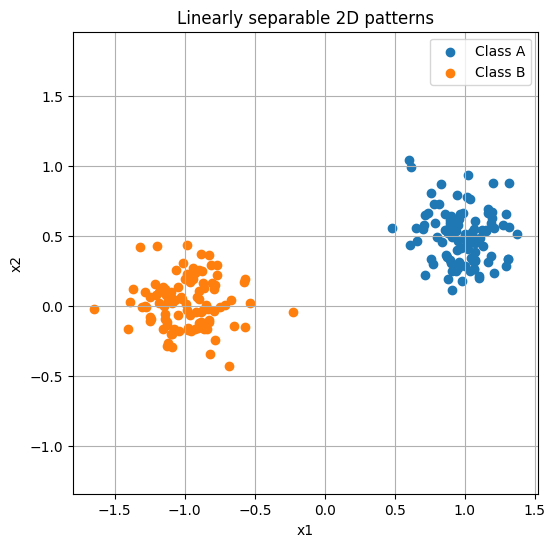

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)

# Number of samples per class
n = 100

# Class A parameters
mA = np.array([1.0, 0.5])
sigmaA = 0.2

# Class B parameters
mB = np.array([-1.0, 0.0])
sigmaB = 0.2

# Generate data (independent dimensions, like the MATLAB code)
classA = np.vstack([
    np.random.randn(n) * sigmaA + mA[0],
    np.random.randn(n) * sigmaA + mA[1]
])

classB = np.vstack([
    np.random.randn(n) * sigmaB + mB[0],
    np.random.randn(n) * sigmaB + mB[1]
])

# Stack data and labels
X = np.hstack([classA, classB])           # shape: (2, 2n)
y = np.hstack([np.ones(n), -np.ones(n)])  # labels: +1 for A, -1 for B

# Shuffle samples (important for sequential / online learning)
perm = np.random.permutation(2 * n)
X = X[:, perm]
y = y[perm]

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(classA[0], classA[1], c='tab:blue', label='Class A')
plt.scatter(classB[0], classB[1], c='tab:orange', label='Class B')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Linearly separable 2D patterns')
plt.grid(True)
plt.axis('equal')
plt.show()


### 3.1.2 Classification with a single-layer perceptron and analysis

[Perceptron] eta=0.0001 final miscls=0
[Perceptron] eta=0.001 final miscls=0
[Perceptron] eta=0.01 final miscls=0
[Perceptron] eta=0.1 final miscls=0
[Delta online] eta=0.0001 final miscls=0 final MSE=0.279198
[Delta online] eta=0.001 final miscls=0 final MSE=0.035664
[Delta online] eta=0.01 final miscls=0 final MSE=0.035763
[Delta online] eta=0.1 final miscls=0 final MSE=0.040849


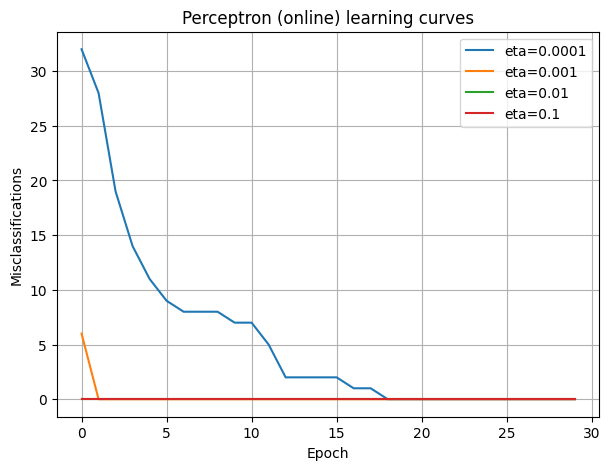

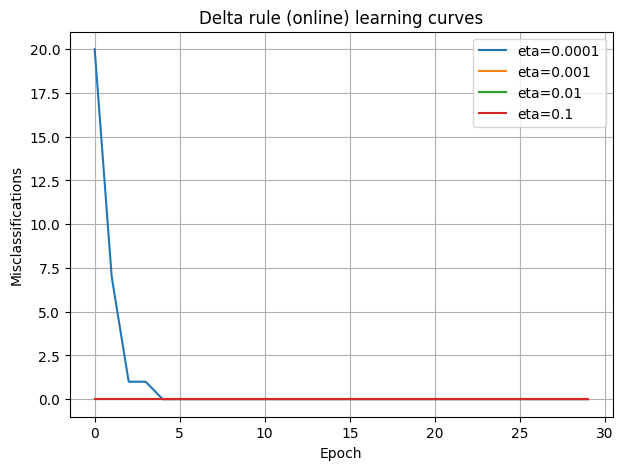

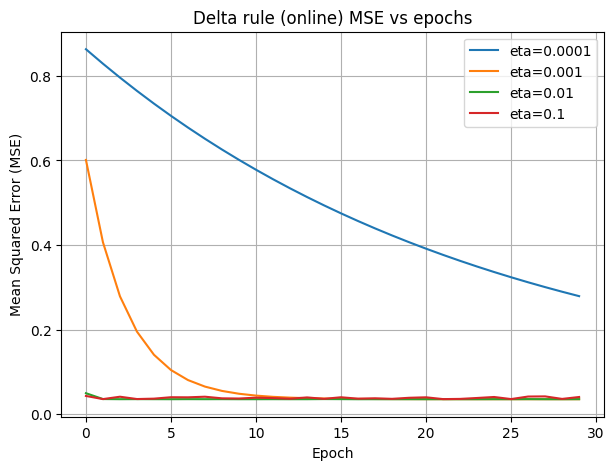

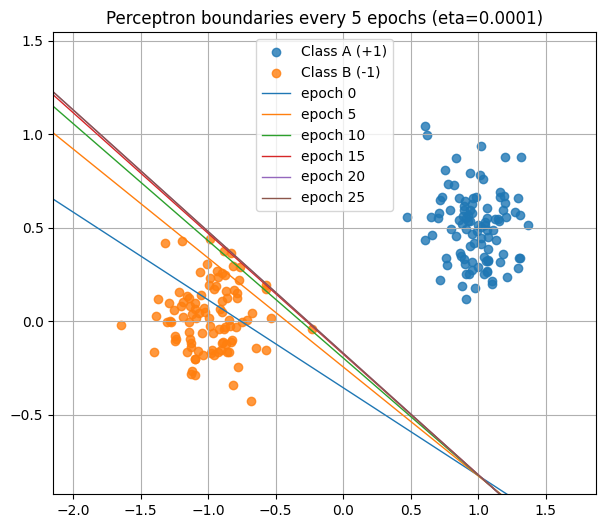

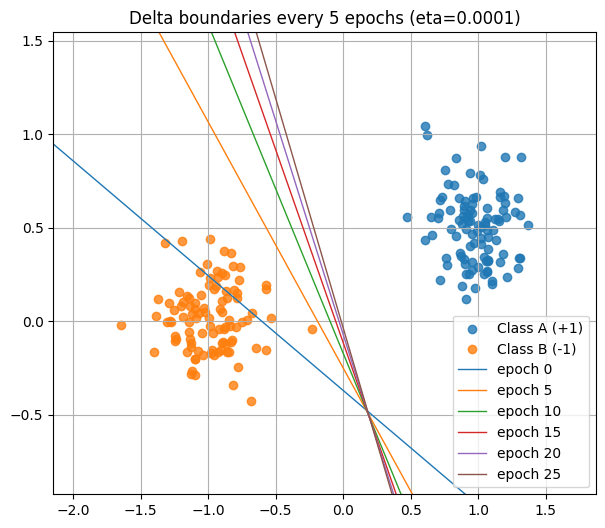

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1) DATA (you can keep your parameters here)
# ============================================================
np.random.seed(42)

n = 100
mA = np.array([1.0, 0.5]); sigmaA = 0.2
mB = np.array([-1.0, 0.0]); sigmaB = 0.2

classA = np.vstack([
    np.random.randn(n) * sigmaA + mA[0],
    np.random.randn(n) * sigmaA + mA[1]
])
classB = np.vstack([
    np.random.randn(n) * sigmaB + mB[0],
    np.random.randn(n) * sigmaB + mB[1]
])

X = np.hstack([classA, classB])                 # (2, 2n)
y = np.hstack([np.ones(n), -np.ones(n)])        # (2n,)

perm = np.random.permutation(2 * n)
X = X[:, perm]
y = y[perm]

# ============================================================
# 2) HELPERS
# ============================================================
def add_bias_row(X):
    return np.vstack([X, np.ones((1, X.shape[1]))])  # (3, N)

def predict_bipolar(W, Xb):
    s = W @ Xb
    return np.where(s >= 0, 1.0, -1.0)

def misclassifications(W, Xb, y):
    yhat = predict_bipolar(W, Xb)
    return int(np.sum(yhat != y))

def mean_squared_error(W, Xb, y):
    s = W @ Xb
    return np.mean((y - s) ** 2)

def fixed_axis_limits(X, pad=0.5):
    xmin, xmax = X[0].min() - pad, X[0].max() + pad
    ymin, ymax = X[1].min() - pad, X[1].max() + pad
    return xmin, xmax, ymin, ymax

def compute_boundary_line(W, xmin, xmax, ymin, ymax, npoints=200):
    w1, w2, b = W
    xs = np.linspace(xmin, xmax, npoints)

    if abs(w2) < 1e-12:
        if abs(w1) < 1e-12:
            return np.array([]), np.array([])
        x0 = -b / w1
        return np.array([x0, x0]), np.array([ymin, ymax])

    ys = -(w1 * xs + b) / w2
    return xs, ys

# ============================================================
# 3) TRAINING (ONLINE)
# ============================================================
def train_perceptron_online(Xb, y, eta=0.01, epochs=50, seed=0, shuffle_each_epoch=True):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))
    N = Xb.shape[1]

    W_history = []
    mis_curve = []

    for ep in range(epochs):
        idx = rng.permutation(N) if shuffle_each_epoch else np.arange(N)
        for i in idx:
            x = Xb[:, i]
            t = y[i]
            s = W @ x
            yhat = 1.0 if s >= 0 else -1.0
            if yhat != t:
                W = W + eta * t * x

        W_history.append(W.copy())
        mis_curve.append(misclassifications(W, Xb, y))

    return W, np.array(mis_curve), W_history

def train_delta_online(Xb, y, eta=0.001, epochs=50, seed=0, shuffle_each_epoch=True):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))
    N = Xb.shape[1]

    W_history = []
    mis_curve = []
    mse_curve = []

    for ep in range(epochs):
        idx = rng.permutation(N) if shuffle_each_epoch else np.arange(N)
        for i in idx:
            x = Xb[:, i]
            t = y[i]
            s = W @ x
            e = (t - s)
            W = W + eta * e * x

        W_history.append(W.copy())
        mis_curve.append(misclassifications(W, Xb, y))
        mse_curve.append(mean_squared_error(W, Xb, y))

    return W, np.array(mis_curve), np.array(mse_curve), W_history

# ============================================================
# 4) PLOTTING / VISUALS
# ============================================================
def animate_training(X, y, W_history, title_prefix="", pause=0.4, pad=0.5):
    Xb_dummy = add_bias_row(X)
    xmin, xmax, ymin, ymax = fixed_axis_limits(X, pad=pad)

    plt.ion()
    fig, ax = plt.subplots(figsize=(7, 6))

    A = X[:, y == 1]
    B = X[:, y == -1]
    ax.scatter(A[0], A[1], label="Class A (+1)", alpha=0.8)
    ax.scatter(B[0], B[1], label="Class B (-1)", alpha=0.8)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
    ax.legend()

    line, = ax.plot([], [], linewidth=2)
    title = ax.set_title("")

    for ep, W in enumerate(W_history, start=1):
        xs, ys = compute_boundary_line(W, xmin, xmax, ymin, ymax)
        line.set_data(xs, ys)

        mis = misclassifications(W, Xb_dummy, y)
        title.set_text(f"{title_prefix} | epoch={ep} | miscls={mis}")

        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(pause)

    plt.ioff()
    plt.show()

def plot_boundaries_every_k_epochs(X, y, W_history, k=5, title=""):
    xmin, xmax, ymin, ymax = fixed_axis_limits(X, pad=0.5)

    plt.figure(figsize=(7, 6))
    ax = plt.gca()

    A = X[:, y == 1]
    B = X[:, y == -1]
    ax.scatter(A[0], A[1], label="Class A (+1)", alpha=0.8)
    ax.scatter(B[0], B[1], label="Class B (-1)", alpha=0.8)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

    for ep in range(1, len(W_history) + 1, k):  # epoch 1,6,11,... if k=5
        W = W_history[ep - 1]
        xs, ys = compute_boundary_line(W, xmin, xmax, ymin, ymax)
        ax.plot(xs, ys, linewidth=1, label=f"epoch {ep-1}")

    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_curve_epoch_grid(values, ylabel, title):
    epochs = len(values)
    xs = np.arange(1, epochs + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, values)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)

    # show 1,2,3,... ticks (fine for <= ~25; for 50 it gets crowded but works)
    plt.xticks(xs)
    plt.grid(True)
    plt.show()

# ============================================================
# 5) MAIN RUN: compare etas + boundaries + MSE for delta
# ============================================================
def run_part_3_1_2_task1(X, y,
                         perceptron_etas=(0.0001, 0.001, 0.01),
                         delta_etas=(0.0001, 0.001, 0.01),
                         epochs=20,
                         seed=1,
                         animate=False,
                         animation_pause=0.4):

    Xb = add_bias_row(X)

    # ---- Perceptron runs ----
    perc_runs = []
    for eta in perceptron_etas:
        W, mis_curve, Whist = train_perceptron_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        perc_runs.append((eta, W, mis_curve, Whist))
        print(f"[Perceptron] eta={eta} final miscls={mis_curve[-1]}")

    # ---- Delta runs ----
    delta_runs = []
    for eta in delta_etas:
        W, mis_curve, mse_curve, Whist = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        delta_runs.append((eta, W, mis_curve, mse_curve, Whist))
        print(f"[Delta online] eta={eta} final miscls={mis_curve[-1]} final MSE={mse_curve[-1]:.6f}")

    # ---- Learning curves (misclassifications) ----
    plt.figure(figsize=(7, 5))
    for eta, W, mis_curve, _ in perc_runs:
        plt.plot(range(0, len(mis_curve)), mis_curve, label=f"eta={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title("Perceptron (online) learning curves")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 5))
    for eta, W, mis_curve, mse_curve, _ in delta_runs:
        plt.plot(range(0, len(mis_curve)), mis_curve, label=f"eta={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title("Delta rule (online) learning curves")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Delta MSE curves (THIS is what you asked to add) ----
    plt.figure(figsize=(7, 5))
    for eta, W, mis_curve, mse_curve, _ in delta_runs:
        plt.plot(range(0, len(mse_curve)), mse_curve, label=f"eta={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Delta rule (online) MSE vs epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Best runs (lowest final miscls) ----
    best_perc = min(perc_runs, key=lambda r: r[2][-1])
    best_delta = min(delta_runs, key=lambda r: r[2][-1])

    # ---- Plot boundaries every 5 epochs for best runs ----
    eta_p, Wp, _, hist_p = best_perc
    plot_boundaries_every_k_epochs(X, y, hist_p, k=5,
        title=f"Perceptron boundaries every 5 epochs (eta={eta_p})")

    eta_d, Wd, _, mse_d, hist_d = best_delta
    plot_boundaries_every_k_epochs(X, y, hist_d, k=5,
        title=f"Delta boundaries every 5 epochs (eta={eta_d})")

    # ---- Optional: animate best runs (epoch-by-epoch) ----
    if animate:
        animate_training(X, y, hist_p, title_prefix=f"Perceptron (eta={eta_p})", pause=animation_pause)
        animate_training(X, y, hist_d, title_prefix=f"Delta online (eta={eta_d})", pause=animation_pause)

# ============================================================
# RUN IT
# ============================================================
run_part_3_1_2_task1(
    X, y,
    perceptron_etas=(0.0001, 0.001, 0.01, 0.1),
    delta_etas=(0.0001, 0.001, 0.01, 0.1),
    epochs=30,
    seed=1,
    animate=False,          # set True if you want animation
    animation_pause=0.5
)

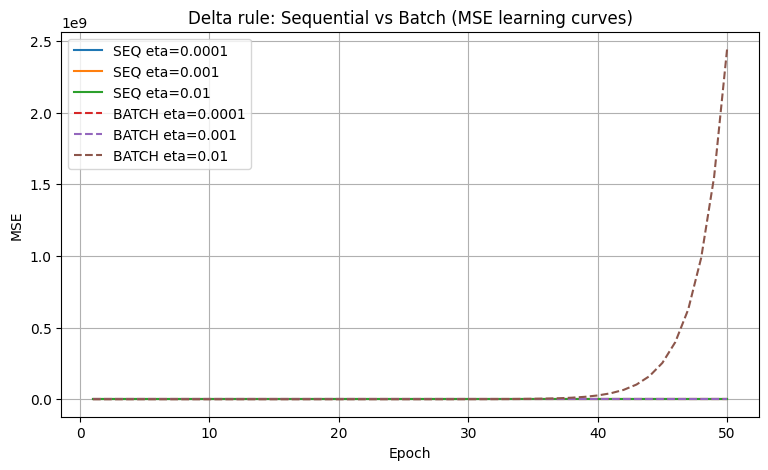

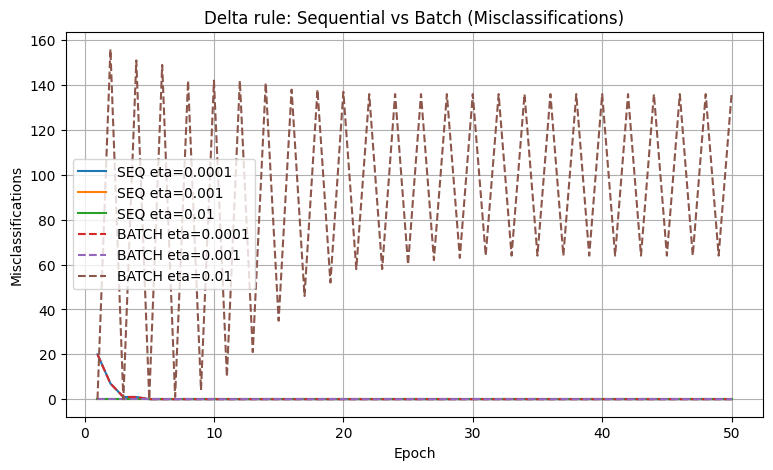


Epochs to reach MSE < 0.01
eta= 0.0001: SEQ -> None,  BATCH -> None
eta=  0.001: SEQ -> None,  BATCH -> None
eta=   0.01: SEQ -> None,  BATCH -> None


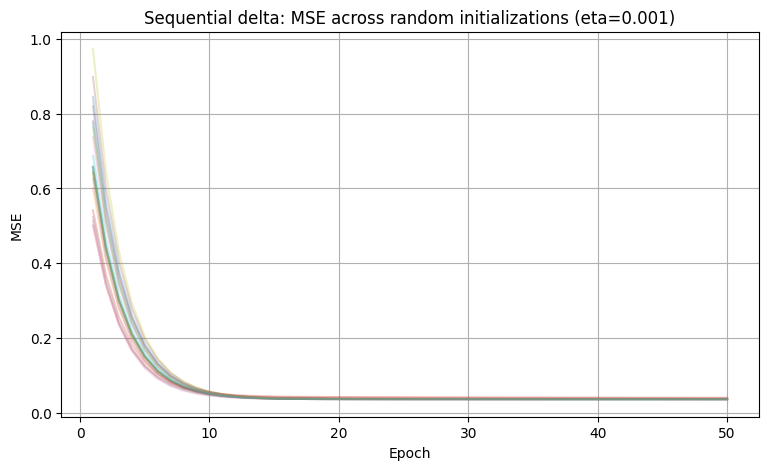

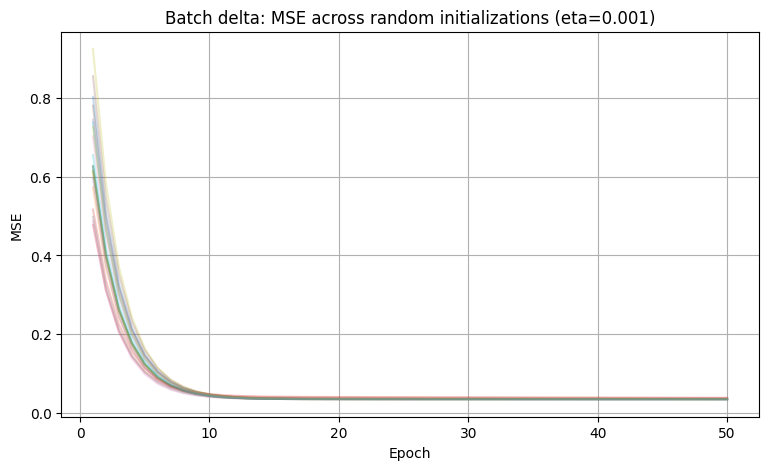


Sensitivity summary (final MSE):
Sequential: mean=0.036201, std=0.000958
Batch:      mean=0.036200, std=0.000956


In [ ]:

def add_bias_row(X):
    return np.vstack([X, np.ones((1, X.shape[1]))])  # (3, N)

def predict_bipolar(W, Xb):
    s = W @ Xb
    return np.where(s >= 0, 1.0, -1.0)

def misclassifications(W, Xb, y):
    yhat = predict_bipolar(W, Xb)
    return int(np.sum(yhat != y))

def mean_squared_error(W, Xb, y):
    s = W @ Xb
    return np.mean((y - s) ** 2)

# ============================================================
# 3) DELTA RULE: SEQUENTIAL (ONLINE)
# ============================================================
def train_delta_online(Xb, y, eta=0.001, epochs=50, seed=0, shuffle_each_epoch=True):
    """
    Sequential (online) delta rule:
      for each sample: W <- W + eta * (t - s) * x
    """
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))  # (d,)
    N = Xb.shape[1]

    mis_curve = []
    mse_curve = []

    for ep in range(epochs):
        idx = rng.permutation(N) if shuffle_each_epoch else np.arange(N)

        for i in idx:
            x = Xb[:, i]
            t = y[i]
            s = W @ x
            e = (t - s)
            W = W + eta * e * x

        mis_curve.append(misclassifications(W, Xb, y))
        mse_curve.append(mean_squared_error(W, Xb, y))

    return W, np.array(mis_curve), np.array(mse_curve)

# ============================================================
# 4) DELTA RULE: BATCH
# ============================================================
def train_delta_batch(Xb, y, eta=0.001, epochs=50, seed=0):
    """
    Batch delta rule (matrix form):
      W <- W - eta * (W X - T) X^T
    where:
      Xb is (d, N), y is (N,), W is (d,)
    """
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))  # (d,)

    mis_curve = []
    mse_curve = []

    XT = Xb.T  # (N, d)

    for ep in range(epochs):
        WX = W @ Xb          # (N,)
        E = (WX - y)         # (N,)  == (W X - T)
        dW = eta * (E @ XT)  # (d,)
        W = W - dW

        mis_curve.append(misclassifications(W, Xb, y))
        mse_curve.append(mean_squared_error(W, Xb, y))

    return W, np.array(mis_curve), np.array(mse_curve)

# ============================================================
# 5) CONVERGENCE MEASURE (epochs until MSE below threshold)
# ============================================================
def epochs_to_mse_threshold(mse_curve, thresh=1e-2):
    hits = np.where(mse_curve < thresh)[0]
    return int(hits[0] + 1) if len(hits) > 0 else None

# ============================================================
# 6) PLOTS: sequential vs batch, multiple etas
# ============================================================
def compare_sequential_vs_batch(X, y, etas=(0.0001, 0.001, 0.01), epochs=50, seed=1, mse_thresh=1e-2):
    Xb = add_bias_row(X)

    # ---- Plot MSE curves (recommended for delta convergence) ----
    plt.figure(figsize=(9, 5))
    for eta in etas:
        _, _, mse_seq = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        plt.plot(range(1, epochs+1), mse_seq, label=f"SEQ eta={eta}")
    for eta in etas:
        _, _, mse_b = train_delta_batch(Xb, y, eta=eta, epochs=epochs, seed=seed)
        plt.plot(range(1, epochs+1), mse_b, linestyle="--", label=f"BATCH eta={eta}")

    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Delta rule: Sequential vs Batch (MSE learning curves)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Plot Misclassification curves (classification performance) ----
    plt.figure(figsize=(9, 5))
    for eta in etas:
        _, mis_seq, _ = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        plt.plot(range(1, epochs+1), mis_seq, label=f"SEQ eta={eta}")
    for eta in etas:
        _, mis_b, _ = train_delta_batch(Xb, y, eta=eta, epochs=epochs, seed=seed)
        plt.plot(range(1, epochs+1), mis_b, linestyle="--", label=f"BATCH eta={eta}")

    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title("Delta rule: Sequential vs Batch (Misclassifications)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Print "how quickly" they converge (epochs to MSE threshold) ----
    print("\nEpochs to reach MSE <", mse_thresh)
    for eta in etas:
        _, _, mse_seq = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        _, _, mse_b = train_delta_batch(Xb, y, eta=eta, epochs=epochs, seed=seed)

        e_seq = epochs_to_mse_threshold(mse_seq, mse_thresh)
        e_b = epochs_to_mse_threshold(mse_b, mse_thresh)

        print(f"eta={eta:>7}: SEQ -> {e_seq},  BATCH -> {e_b}")

# ============================================================
# 7) SENSITIVITY TO RANDOM INITIALISATION (multiple seeds)
# ============================================================
def sensitivity_to_initialization(X, y, eta=0.001, epochs=50, seeds=range(20)):
    Xb = add_bias_row(X)

    final_seq = []
    final_batch = []

    # Sequential: plot many MSE curves faintly
    plt.figure(figsize=(9, 5))
    for s in seeds:
        _, _, mse_seq = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=s)
        plt.plot(range(1, epochs+1), mse_seq, alpha=0.25)
        final_seq.append(mse_seq[-1])
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(f"Sequential delta: MSE across random initializations (eta={eta})")
    plt.grid(True)
    plt.show()

    # Batch: plot many MSE curves faintly
    plt.figure(figsize=(9, 5))
    for s in seeds:
        _, _, mse_b = train_delta_batch(Xb, y, eta=eta, epochs=epochs, seed=s)
        plt.plot(range(1, epochs+1), mse_b, alpha=0.25)
        final_batch.append(mse_b[-1])
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(f"Batch delta: MSE across random initializations (eta={eta})")
    plt.grid(True)
    plt.show()

    print("\nSensitivity summary (final MSE):")
    print(f"Sequential: mean={np.mean(final_seq):.6f}, std={np.std(final_seq):.6f}")
    print(f"Batch:      mean={np.mean(final_batch):.6f}, std={np.std(final_batch):.6f}")

# ============================================================
# 8) RUN EVERYTHING FOR PART 2
# ============================================================
if __name__ == "__main__":
    # Compare sequential vs batch delta for multiple learning rates
    compare_sequential_vs_batch(
        X, y,
        etas=(0.0001, 0.001, 0.01, 0.1),
        epochs=50,
        seed=1,
        mse_thresh=1e-2
    )

    # Check sensitivity to random initialization (same eta, many seeds)
    sensitivity_to_initialization(
        X, y,
        eta=0.001,
        epochs=50,
        seeds=range(20)
    )
